## Regression with statsmodels

In [3]:
from lib import utilities as util
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)


sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [4]:
trainDf = spark.read.parquet(".data/trainDf.parquet")
validDf = spark.read.parquet(".data/validDf.parquet")

studyVars = [
  'student_duration_mins',
  'timeliness_duration_mins',
 'item_attempt_duration_mins',
  'item_type_code_name_swoe',
  'number_of_distinct_instance_items'
]

###### Create regression dataframe
 - completed items
 - study variables
  - target
  - student_duration_mins
  - timeliness_duration_mins
  - item_attempt_duration_mins
  - item_type_code_name_swoe
  - number_of_distinct_instance_items

In [5]:
trnDf = trainDf.select('target',*studyVars).toPandas()
valDf = validDf.select('target',*studyVars).toPandas()

###### Dataframe structure

In [6]:
trnDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47201 entries, 0 to 47200
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   target                             47201 non-null  int32  
 1   student_duration_mins              47201 non-null  float64
 2   timeliness_duration_mins           47201 non-null  float64
 3   item_attempt_duration_mins         47201 non-null  float64
 4   item_type_code_name_swoe           47201 non-null  float64
 5   number_of_distinct_instance_items  47201 non-null  int32  
dtypes: float64(4), int32(2)
memory usage: 1.8 MB


###### Target variable barplot

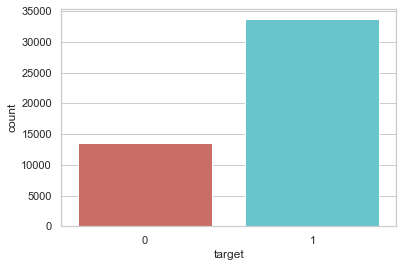

In [7]:
sns.countplot(x='target',data=trnDf, palette='hls')
plt.show()

###### Target variable percentages

In [8]:
count_no_pass = len(trnDf[trnDf['target'] == 0])
count_pass = len(trnDf[trnDf['target'] == 1])
pct_of_no_pass = count_no_pass / (count_no_pass+count_pass)
print("percentage of no pass is", round(pct_of_no_pass * 100), '%')
pct_of_pass = count_pass/(count_no_pass + count_pass)
print("percentage of passes", round(pct_of_pass * 100), '%')

percentage of no pass is 29 %
percentage of passes 71 %


###### Number of missing values

In [9]:
trnDf.isnull().sum()

target                               0
student_duration_mins                0
timeliness_duration_mins             0
item_attempt_duration_mins           0
item_type_code_name_swoe             0
number_of_distinct_instance_items    0
dtype: int64

###### Number of distinct instance items histogram

Text(0, 0.5, 'Frequency')

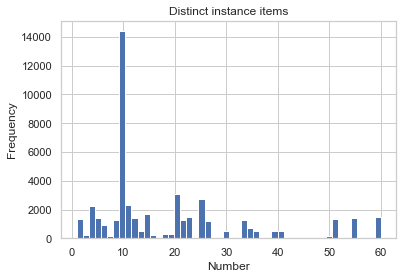

In [10]:
trnDf.number_of_distinct_instance_items.hist(bins=50)
plt.title('Distinct instance items')
plt.xlabel('Number')
plt.ylabel('Frequency')

###### Target vs number of distinct instance items scatter plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


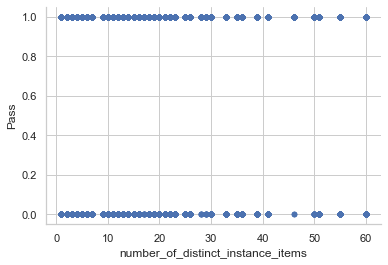

In [11]:
trnDf.plot.scatter('number_of_distinct_instance_items', 'target')
plt.ylabel('Pass')
sns.despine()

###### Item type code name swoe histogram

Text(0, 0.5, 'Frequency')

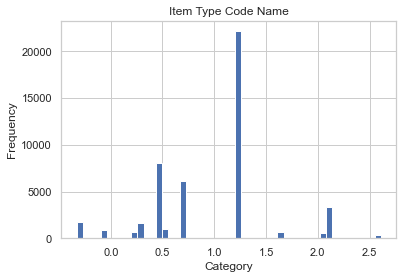

In [12]:
trnDf.item_type_code_name_swoe.hist(bins=50)
plt.title('Item Type Code Name')
plt.xlabel('Category')
plt.ylabel('Frequency')

###### Target vs item type code name scatter plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


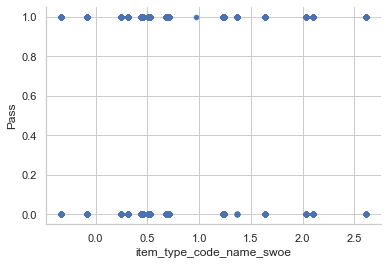

In [13]:
trnDf.plot.scatter('item_type_code_name_swoe', 'target')
plt.ylabel('Pass')
sns.despine()

###### Attempt duration minutes histogram

Text(0, 0.5, 'Frequency')

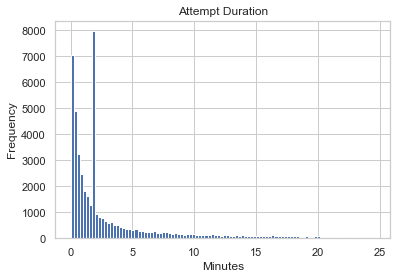

In [14]:
trnDf.item_attempt_duration_mins.hist(bins=100)
plt.title('Attempt Duration')
plt.xlabel('Minutes')
plt.ylabel('Frequency')

###### Target vs Attempt duration minutes scatter plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


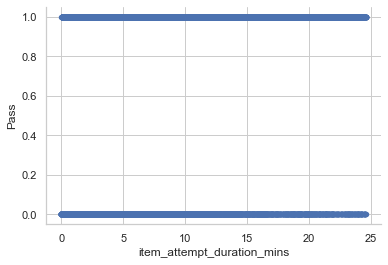

In [15]:
trnDf.plot.scatter('item_attempt_duration_mins', 'target')
plt.ylabel('Pass')
sns.despine()

###### Student duration minutes histogram

Text(0, 0.5, 'Frequency')

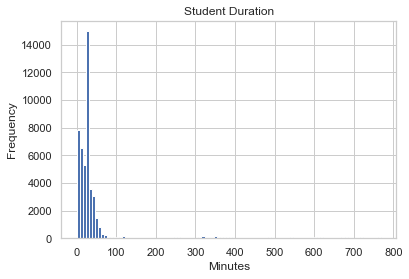

In [16]:
trnDf.student_duration_mins.hist(bins=100)
plt.title('Student Duration')
plt.xlabel('Minutes')
plt.ylabel('Frequency')

###### Target vs Student duration minutes scatter plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


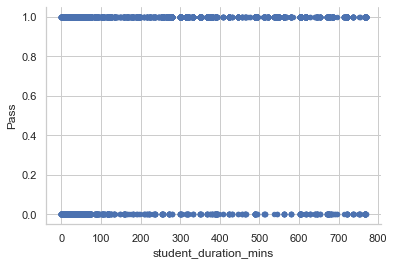

In [17]:
trnDf.plot.scatter('student_duration_mins', 'target')
plt.ylabel('Pass')
sns.despine()


###### Timeliness duration minutes histogram

Text(0, 0.5, 'Frequency')

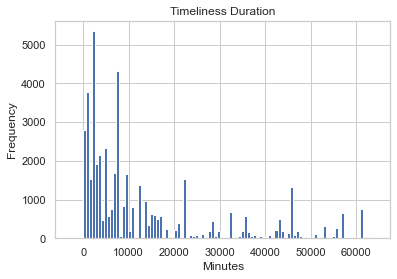

In [18]:
trnDf.timeliness_duration_mins.hist(bins=100)
plt.title('Timeliness Duration')
plt.xlabel('Minutes')
plt.ylabel('Frequency')

###### Target vs Timeliness duration minutes scatter plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


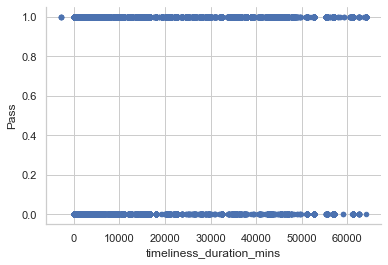

In [19]:
trnDf.plot.scatter('timeliness_duration_mins', 'target')
plt.ylabel('Pass')
sns.despine()

###### Check the independence between the independent variables

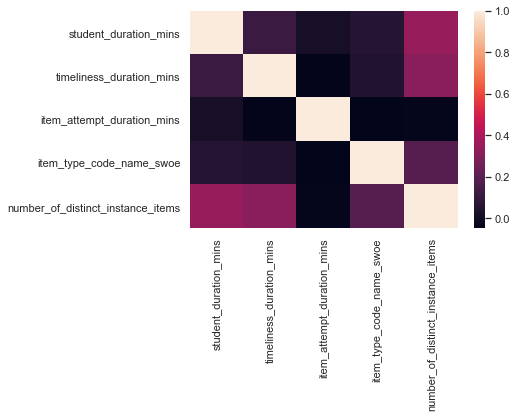

In [20]:
sns.heatmap( trnDf[trnDf.columns.intersection(studyVars)].corr())
plt.show()

Correlation less than .5

###### Train

In [21]:
y_train = trnDf[['target']]
X_train = trnDf[studyVars]

logreg = sm.Logit(y_train, X_train).fit()

logreg.summary()

Optimization terminated successfully.
         Current function value: 0.565841
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                47201
Model:                          Logit   Df Residuals:                    47196
Method:                           MLE   Df Model:                            4
Date:                Fri, 13 Nov 2020   Pseudo R-squ.:                 0.05524
Time:                        18:29:30   Log-Likelihood:                -26708.
converged:                       True   LL-Null:                       -28270.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
student_duration_mins                 0.0007      0.000      5.695      0.000       0.000       0.001
timeliness_duration_mins           1.888e-06   7.19e-07      2.625      0.009    4.78e-07     3.3e-06
item_attempt_duration_mins           -0.0075      0.002     -3.829      0.000      -0.011      -0.004
item_type_code_name_swoe              0.8831      0.016     56.959      0.000       0.853       0.914
number_of_distinct_instance_items     0.0059      0.001      7.133      0.000       0.004       0.008
=====================================================================================================
"""

###### Validate

In [22]:
y_valid = trnDf[['target']]
X_valid = trnDf[studyVars]

yhat = logreg.predict(X_valid)
prediction = list(map(round, yhat))
#
# # comparing original and predicted values of y
# print('Actual values', list(y_valid.values))
# print('Predictions :', prediction)

###### Test Accuracy

In [23]:
from sklearn.metrics import (confusion_matrix,
                           accuracy_score)

# confusion matrix
cm = confusion_matrix(y_valid, prediction)
print ("Confusion Matrix : \n", cm)

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_valid, prediction))

Confusion Matrix : 
 [[ 1069 12451]
 [  799 32882]]
Test accuracy =  0.7192856083557552


###### Reciever Operating Characteristic (ROC) Curve

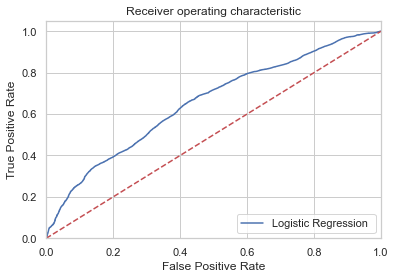

In [24]:
# Ref: https://jbhender.github.io/Stats506/F18/GP/Group5.html

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# logit_roc_auc = roc_auc_score(y, pred)
fpr, tpr, thresholds = roc_curve(y_valid, yhat)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression ')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [25]:
from lib import stepwise

sout = stepwise.forwardSelection(X_train, y_train, model_type ="logistic")

Character Variables (Dummies Generated, First Dummies Dropped): []
Optimization terminated successfully.
         Current function value: 0.598928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567887
         Iterations 5
Entered : item_type_code_name_swoe 	AIC : 53613.67536049645
Optimization terminated successfully.
         Current function value: 0.566778
         Iterations 5
Optimization terminated successfully.
         Current fu

In [26]:
from lib import stepwise

sout = stepwise.backwardSelection(X_train, y_train, model_type ="logistic")

Character Variables (Dummies Generated, First Dummies Dropped): []
Optimization terminated successfully.
         Current function value: 0.565222
         Iterations 6
Eliminated : item_attempt_duration_mins
Optimization terminated successfully.
         Current function value: 0.565230
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                47201
Model:                          Logit   Df Residuals:                    47196
Method:                           MLE   Df Model:                            4
Date:                Fri, 13 Nov 2020   Pseudo R-squ.:                 0.05626
Time:                        18:29:32   Log-Likelihood:                -26679.
converged:                       True   LL-Null:                       -28270.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err  